In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import healpy as hp
import pandas as pd
import glob
import os
import pytz 
import pyulog
import pyulog.core as pyu
import pyulog.ulog2csv as pyucsv
import ECHO
from ECHO import plot_utils
from ECHO.read_utils import read_ulog, read_tlog_txt, mission_endpoint_flagging, read_map
from ECHO.plot_utils import grid_to_healpix, make_polycoll,project_healpix,fmt,nf,cmap_discretize,get_interp_val
from ECHO.position_utils import latlon2xy,to_spherical
from scipy.interpolate import interp1d
from astropy.time import Time
from matplotlib import ticker,cm

In [2]:
rxdir = '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data/'
logdir = '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_Flightlogs/'

In [3]:
#Map1 ulog
map1_global_arr, map1_local_arr, map1_gps_arr = read_ulog(logdir +'Map1/log_2_2021-5-9-07-58-54.ulg')
#Map1 tlog
map1_wp_arr, map1_global_arr_t, map1_local_arr_t, map1_gps_arr_t = read_tlog_txt(logdir + '/Map1/2021-05-09 08-08-07.txt')

#Map2 ulog
map2_global_arr, map2_local_arr, map2_gps_arr = read_ulog(logdir +'top_hat/log_8_2021-5-9-09-49-50.ulg')
#Map2 tlog
map2_wp_arr, map2_global_arr_t, map2_local_arr_t, map2_gps_arr_t = read_tlog_txt(logdir + 'top_hat/2021-05-09 09-53-43.txt')

In [4]:
#getting vehicle attitude data (roll,pitch,yaw) for map1, already extracted for map2
ulog_file = logdir +'Map1/log_2_2021-5-9-07-58-54.ulg'
pyucsv.convert_ulog2csv(ulog_file, messages='vehicle_attitude',
                        output='/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_Flightlogs/Map1/',
                        delimiter=',')

In [5]:
map1_vehicle_att = np.genfromtxt(logdir+ 'Map1/log_2_2021-5-9-07-58-54_vehicle_attitude_0.csv',
                            delimiter = ',', skip_header=1)
map2_vehicle_att = np.genfromtxt(logdir+ 'top_hat/log_8_2021-5-9-09-49-50_vehicle_attitude_0.csv',
                            delimiter = ',', skip_header=1)


### Adding bootstart times

In [6]:
#Map1 
map1_bootstart = map1_gps_arr[0][1]- map1_gps_arr[0][0]
map1_global_arr[:,0] = map1_global_arr[:,0]+ map1_bootstart
map1_local_arr[:,0] = map1_local_arr[:,0]+ map1_bootstart
map1_local_arr = np.delete(map1_local_arr,1,1)
map1_gps_arr[:,0] = map1_gps_arr[:,0]+ map1_bootstart
map1_gps_arr = np.delete(map1_gps_arr,1,1)
map1_vehicle_att[:,0]= (map1_vehicle_att[:,0]/1e6)+ map1_bootstart

map1_global_arr_t[:,0] = map1_global_arr_t[:,1]+ map1_bootstart
map1_global_arr_t = np.delete(map1_global_arr_t,1,1)
map1_local_arr_t[:,0] = map1_local_arr_t[:,1]+ map1_bootstart
map1_local_arr_t = np.delete(map1_local_arr_t,1,1)
map1_gps_arr_t[:,0] = map1_gps_arr_t[:,1]+ map1_bootstart
map1_gps_arr_t = np.delete(map1_gps_arr_t,1,1)

#Map2
map2_bootstart = map2_gps_arr[0][1]- map2_gps_arr[0][0]
map2_global_arr[:,0] = map2_global_arr[:,0]+ map2_bootstart
map2_local_arr[:,0] = map2_local_arr[:,0]+ map2_bootstart
map2_local_arr = np.delete(map2_local_arr,1,1)
map2_gps_arr[:,0] = map2_gps_arr[:,0]+ map2_bootstart
map2_gps_arr = np.delete(map2_gps_arr,1,1)
map2_vehicle_att[:,0]= (map2_vehicle_att[:,0]/1e6)+ map2_bootstart

map2_global_arr_t[:,0] = map2_global_arr_t[:,1]+ map2_bootstart
map2_global_arr_t = np.delete(map2_global_arr_t,1,1)
map2_local_arr_t[:,0] = map2_local_arr_t[:,1]+ map2_bootstart
map2_local_arr_t = np.delete(map2_local_arr_t,1,1)
map2_gps_arr_t[:,0] = map2_gps_arr_t[:,1]+ map2_bootstart
map2_gps_arr_t = np.delete(map2_gps_arr_t,1,1)

<IPython.core.display.Javascript object>


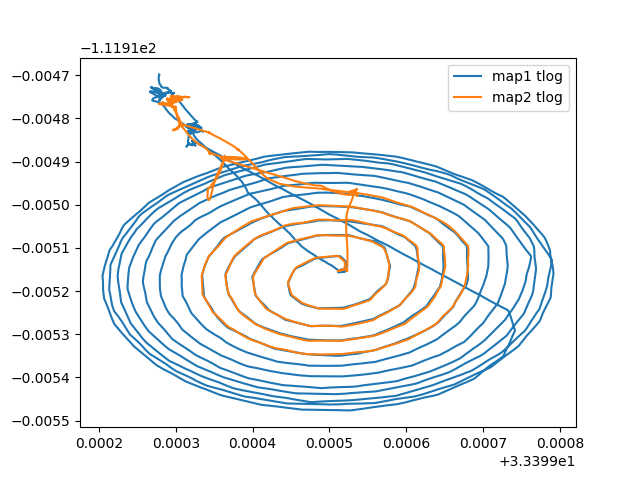

In [7]:
plt.figure()
#plt.plot(map1_global_arr[:,1], map1_global_arr[:,2], label = 'map1')
#plt.plot(map2_global_arr[:,1], map2_global_arr[:,2], label = 'map2')
plt.plot(map1_global_arr_t[:,1], map1_global_arr_t[:,2], label = 'map1 tlog')
plt.plot(map2_global_arr_t[:,1], map2_global_arr_t[:,2], label = 'map2 tlog')
plt.legend()

In [8]:
#flag take off and landing in map 1
map1_flagged_drone_pos, map1_drone_pos_t = mission_endpoint_flagging(map1_global_arr_t, map1_wp_arr)
#map2_flagged_drone_pos, map2_drone_pos_t = mission_endpoint_flagging(map2_global_arr_t, map2_wp_arr)

In [ ]:
#plt.figure()
#plt.plot(map1_drone_pos_t[:,1],map1_drone_pos_t[:,2])
#plt.scatter(map2_drone_pos_t[:,1],map2_drone_pos_t[:,2])

### Tweaking waypoint condition in the flagging function

In [9]:
def map2_mission_endpoint_flagging(pos_data,wpt_data):
    flagged_indices = []
    mission_indices = []
    mission_start = 0
    mission_end = wpt_data[-1][0]
    
    for row in wpt_data:
        if row[1] == 215:
            mission_start = row[0]
            break
    
    for index,row in enumerate(pos_data):
        if row[0]<mission_start or row[0]>mission_end: flagged_indices.append(index)
        else: mission_indices.append(index)
    
    flagged_data = np.delete(pos_data,mission_indices,0)
    mission_data = np.delete(pos_data,flagged_indices,0)
    return flagged_data, mission_data

In [10]:
def map1_mission_endpoint_flagging(pos_data,wpt_data):
    flagged_indices = []
    mission_indices = []
    mission_start = 0
    mission_end = wpt_data[-1][0]
    
    for row in wpt_data:
        if row[1] == 216:
            mission_start = row[0]
            break
    
    for index,row in enumerate(pos_data):
        if row[0]<mission_start or row[0]>mission_end: flagged_indices.append(index)
        else: mission_indices.append(index)
    
    flagged_data = np.delete(pos_data,mission_indices,0)
    mission_data = np.delete(pos_data,flagged_indices,0)
    return flagged_data, mission_data

In [11]:
map2_flagged_drone_pos, map2_drone_pos_t = map2_mission_endpoint_flagging(map2_global_arr_t, map2_wp_arr)

In [12]:
#get map1 top sortie position data
map1_top_flag, map1_top_mission = map1_mission_endpoint_flagging(map1_drone_pos_t, map1_wp_arr)

In [ ]:
map1_top_mission

In [13]:
#get map1 without top sortie 
map1_without_top = map1_drone_pos_t[map1_drone_pos_t[:,0] <= map1_top_mission[1,0]]

#concatenate separately flown top sortie with map1 
concat_drone_pos = np.concatenate((map1_without_top,map2_drone_pos_t))

<IPython.core.display.Javascript object>


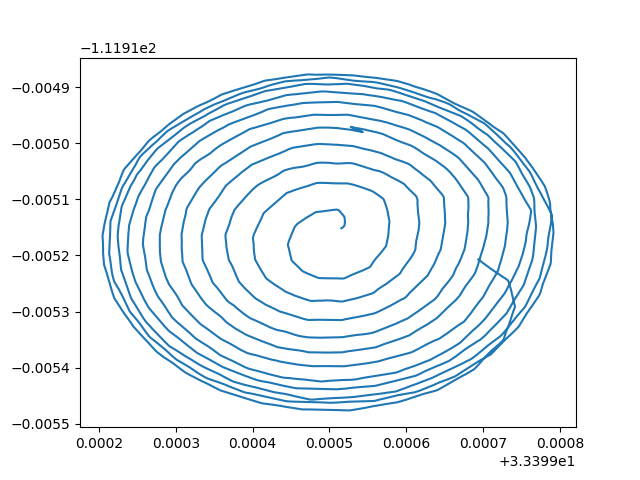

In [14]:
plt.figure()
#plt.plot(map1_drone_pos_t[:,1],map1_drone_pos_t[:,2])
#plt.scatter(map2_drone_pos_t[:,1],map2_drone_pos_t[:,2])
#plt.plot(test_mission[:,1], test_mission[:,2], 'r')
#plt.plot(map1_drone_pos_t[map1_drone_pos_t[:,0] <= test_mission[1,0]][:,1], map1_drone_pos_t[map1_drone_pos_t[:,0] <= test_mission[1,0]][:,2])
plt.plot(concat_drone_pos[:,1], concat_drone_pos[:,2])

In [15]:
map1_rx_files = glob.glob(rxdir + '/Mapping_run1/*.csv')
map2_rx_files = glob.glob(rxdir + '/top_hat_run/*.csv')

In [16]:
map2_rx_files

['/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//top_hat_run/0.csv',
 '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//top_hat_run/1.csv',
 '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//top_hat_run/2.csv']

In [17]:
def get_rtsa_data(rx_files):
    final_df = []
    for file in rx_files:
        print(file)
        data = pd.read_csv(file,skiprows = 17,header=None)
        data=data.drop([0,2,3,4],axis=1)
        with open(file,'r') as f:
            for i,line in enumerate(f):
                if 'Freq Hz' in line:
                    break
        cols=line.split(',')[5:]
        cols = ['Datetime'] + cols
        data.columns=cols
        final_df.append(data)
    return pd.concat(final_df,ignore_index=True)

In [18]:
map1_rx_data = get_rtsa_data(map1_rx_files)
map2_rx_data = get_rtsa_data(map2_rx_files)

/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/0.csv


/home/mrudula/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/1.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/2.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/3.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/4.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/5.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//top_hat_run/0.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//top_hat_run/1.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//top_hat_run/2.csv


In [19]:
map1_rx_data['Datetime'] =  pd.to_datetime(map1_rx_data['Datetime'])
map2_rx_data['Datetime'] = pd.to_datetime(map2_rx_data['Datetime'])

In [20]:
map1_rx_times = map1_rx_data['Datetime'].dt.tz_localize('US/Arizona').dt.tz_convert('utc')
map2_rx_times = map2_rx_data['Datetime'].dt.tz_localize('US/Arizona').dt.tz_convert('utc')

In [ ]:
'''temp_df = pd.DataFrame({'a':range(global_arr.shape[0])})
temp_df['date'] = global_arr[:,0]
temp_df['date'] = pd.to_datetime(temp_df['date'],unit='s')
drone_times = temp_df['date'].dt.tz_localize('utc')'''

In [21]:
map1_drone_times = Time(map1_without_top[:,0], format = 'unix', scale = 'utc')
map2_drone_times = Time(map2_drone_pos_t[:,0], format = 'unix', scale = 'utc')
map1_drone_times.iso[0]

'2021-05-09 14:32:33.096'

In [ ]:
map1_rx_times.values

In [22]:
map1_mission_rx = map1_rx_data[(map1_rx_times.values >= map1_drone_times.datetime64[0]) & 
                     (map1_rx_times.values <= map1_drone_times.datetime64[-1])]
map2_mission_rx = map2_rx_data[(map2_rx_times.values >= map2_drone_times.datetime64[0]) & 
                     (map2_rx_times.values <= map2_drone_times.datetime64[-1])] 
map1_mission_rx_times = map1_rx_times[(map1_rx_times.values >= map1_drone_times.datetime64[0]) & 
                     (map1_rx_times.values <= map1_drone_times.datetime64[-1])]
map2_mission_rx_times = map2_rx_times[(map2_rx_times.values >= map2_drone_times.datetime64[0]) & 
                     (map2_rx_times.values <= map2_drone_times.datetime64[-1])]

In [27]:
map1_mission_vehicle_att = map1_vehicle_att[(Time(map1_vehicle_att[:,0], format ='unix')>= map1_drone_times.datetime64[0]) & 
            (Time(map1_vehicle_att[:,0], format ='unix')<= map1_drone_times.datetime64[-1])]
map2_mission_vehicle_att = map2_vehicle_att[(Time(map2_vehicle_att[:,0], format ='unix')>= map2_drone_times.datetime64[0]) & 
            (Time(map2_vehicle_att[:,0], format ='unix')<= map2_drone_times.datetime64[-1])]

In [24]:
#roll, pitch, yaw. formula from px4 githib: https://github.com/PX4/pyulog/blob/5df97b3248b41a09af5630f1206221b38bfd35f4/pyulog/px4.py#L81
def calc_vehicle_att(vehicle_att_array):
    q = vehicle_att_array[:,1:5]
    roll = np.arctan2(2.0 * (q[:,0] * q[:,1] + q[:,2] * q[:,3]),
                                  1.0 - 2.0 * (q[:,1] * q[:,1] + q[:,2] * q[:,2]))
    pitch = np.arcsin(2.0 * (q[:,0] * q[:,2] - q[:,3] * q[:,1]))
    yaw = np.arctan2(2.0 * (q[:,0] * q[:,3] + q[:,1] * q[:,2]),
                                 1.0 - 2.0 * (q[:,2] * q[:,2] + q[:,3] * q[:,3]))
    return roll, pitch, yaw

In [28]:
map1_roll, map1_pitch, map1_yaw = calc_vehicle_att(map1_mission_vehicle_att)
map2_roll, map2_pitch, map2_yaw = calc_vehicle_att(map2_mission_vehicle_att)

<IPython.core.display.Javascript object>


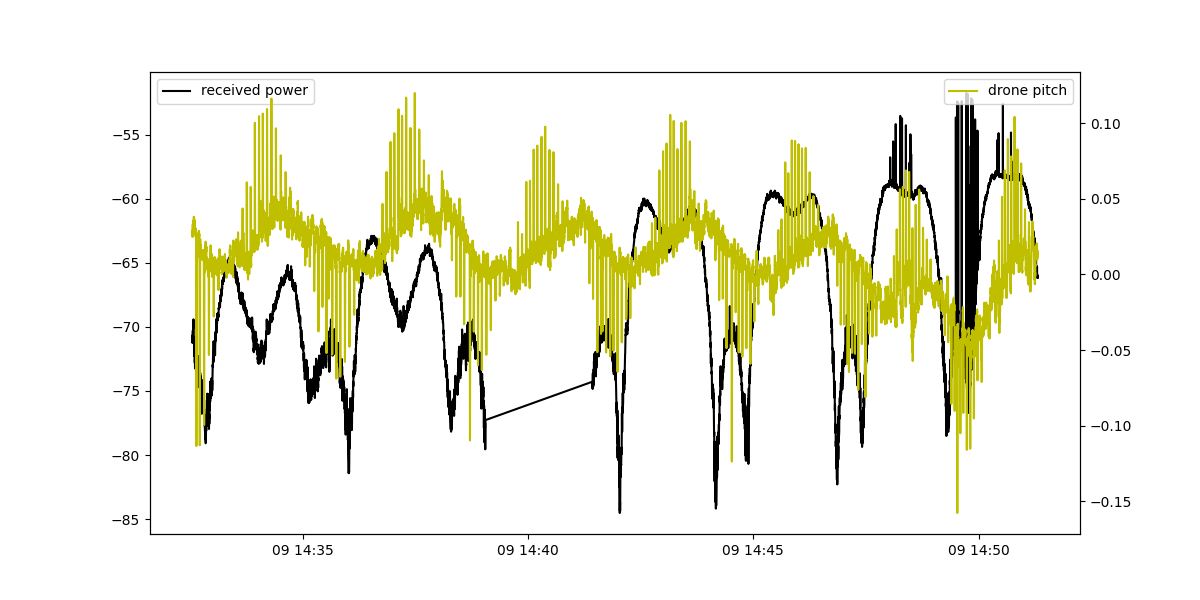

In [43]:
fig, ax = plt.subplots(figsize = (12,6))
ax2 = ax.twinx()
#ax.plot(map1_drone_times.datetime64, map1_without_top[:,3], 'y', marker = 'o', markersize = 5)
ax2.plot((Time(map1_mission_vehicle_att[:,0], format ='unix')).datetime64, map1_pitch, 'y', label = 'drone pitch')
ax.plot(map1_mission_rx_times.values,map1_mission_rx.iloc[:,411].values, 'k', label = 'received power')
ax.legend()
ax2.legend()
#ax2.plot(map1_mission_rx_times.values,map1_mission_rx.iloc[:,407].values, 'r')

<IPython.core.display.Javascript object>


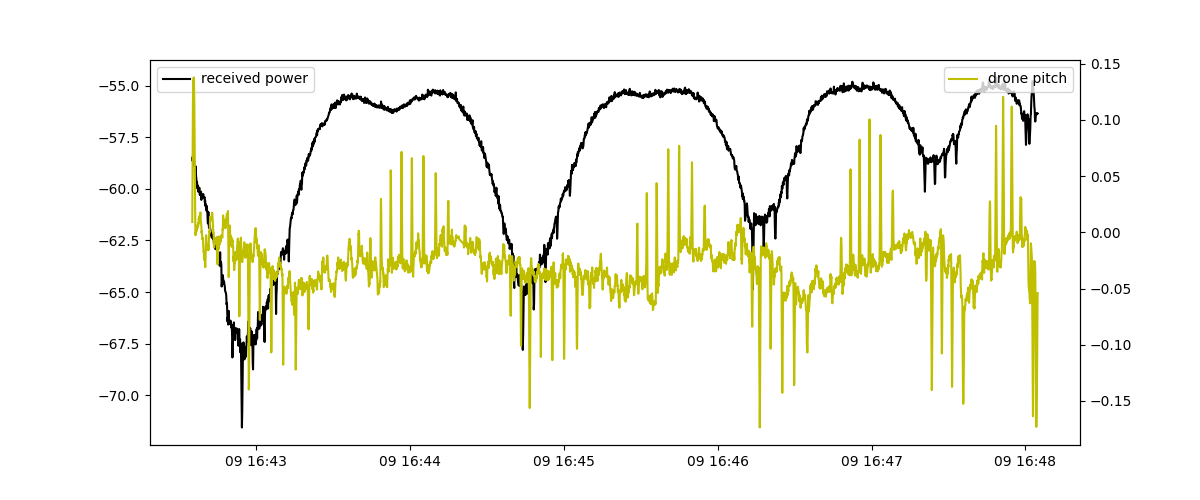

In [51]:
fig, ax = plt.subplots(figsize = (12,5))
ax2 = ax.twinx()
#ax.plot(map2_drone_times.datetime64, map2_drone_pos_t[:,3]+1125, 'y', marker = 'o', markersize = 5)
ax2.plot((Time(map2_mission_vehicle_att[:,0], format ='unix')).datetime64, map2_pitch, 'y', label = 'drone pitch')
ax.plot(map2_mission_rx_times.values,map2_mission_rx.iloc[:,411].values, 'k', label = 'received power')
ax.legend()
ax2.legend()
#ax2.plot(map2_mission_rx_times.values,map2_mission_rx.iloc[:,410].values, 'orange')

In [52]:
#masking to get rid of the blips
map1_mission_rx = map1_mission_rx.iloc[np.ma.where((map1_mission_rx.iloc[:,407]< -79))]
map1_mission_rx_times = map1_mission_rx_times.iloc[np.ma.where((map1_mission_rx.iloc[:,407]< -79))]

<IPython.core.display.Javascript object>


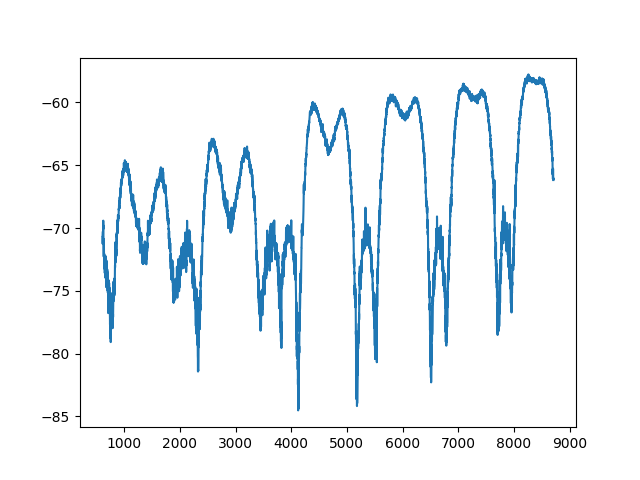

In [53]:
plt.figure()
plt.plot(map1_mission_rx.iloc[:,411])

In [54]:
def interp_rx(postimes,rxtimes,rx):
    power_interp_model = interp1d(rxtimes.gps,rx,bounds_error = False)
    rx_interp = power_interp_model(postimes.gps)
    return rx_interp

In [55]:
#Time(map1_mission_rx_times.values)

In [56]:
map1_interpolated_rx = interp_rx(map1_drone_times,Time(map1_mission_rx_times.values),map1_mission_rx.iloc[:,411])
map2_interpolated_rx = interp_rx(map2_drone_times,Time(map2_mission_rx_times.values),map2_mission_rx.iloc[:,411])

In [57]:
concat_rx_data = np.concatenate((map1_interpolated_rx,map2_interpolated_rx))

<IPython.core.display.Javascript object>


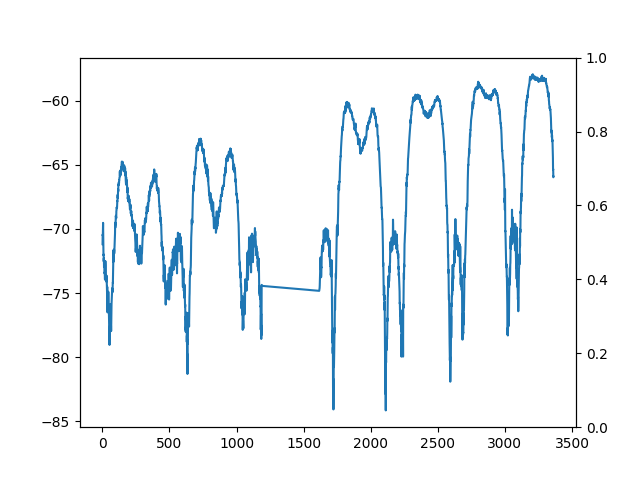

In [58]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
#ax.plot(concat_drone_pos[:,0],concat_rx_data)
#ax2.plot(concat_drone_pos[:,0],concat_drone_pos[:,3], 'r')
#ax2.plot(map1_mission_rx_times.values,map1_mission_rx.iloc[:,411].values, 'k')
ax.plot(map1_interpolated_rx)

## Beammap

In [59]:
alts = concat_drone_pos[:,3]+1125 #global alts are off by +1125. need to figure out why
lat0 = 33.399500
lon0 = -111.915175
hpx_beam,hpx_rms,hpx_counts = grid_to_healpix(concat_drone_pos[:,1],
                                              concat_drone_pos[:,2],
                                              alts,
                                              concat_rx_data,
                                              lat0,lon0,nside = 8)

/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/ECHO/plot_utils.py:169: RuntimeWarning: invalid value encountered in sqrt
  rms *= (1+1./np.sqrt(2*(counts-1)))
/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/ECHO/plot_utils.py:169: RuntimeWarning: divide by zero encountered in true_divide
  rms *= (1+1./np.sqrt(2*(counts-1)))
/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/ECHO/plot_utils.py:169: RuntimeWarning: invalid value encountered in multiply
  rms *= (1+1./np.sqrt(2*(counts-1)))


In [60]:
hpx_beam[np.where(np.isnan(hpx_beam))[0]] = hp.UNSEEN
hpx_counts[np.where(np.isnan(hpx_counts))[0]] = hp.UNSEEN
hpx_rms[np.where(np.isnan(hpx_rms))[0]] = hp.UNSEEN

M = np.ma.array(hpx_beam,fill_value=hp.UNSEEN)
M = np.ma.masked_where(hp.UNSEEN==M,M)
M.fill_value = hp.UNSEEN
beam = M
beam -= beam.max()

In [61]:
R = np.ma.array(hpx_rms,fill_value=hp.UNSEEN)
R = np.ma.masked_where(hp.UNSEEN==R,R)
R.fill_value = hp.UNSEEN
rms = R

In [62]:
rms.max()

6.643112930980181

In [63]:
C = np.ma.array(hpx_counts,fill_value=hp.UNSEEN)
C = np.ma.masked_where(hp.UNSEEN==C,C)
C.fill_value = hp.UNSEEN
counts = C

In [64]:
THETA,PHI,IM = project_healpix(beam)
X,Y = np.meshgrid(
        np.linspace(-1,1,num=THETA.shape[0]),
        np.linspace(-1,1,num=THETA.shape[1]))

/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/ECHO/plot_utils.py:100: RuntimeWarning: invalid value encountered in sqrt
  Z = np.sqrt(1-X**2 - Y**2)


<IPython.core.display.Javascript object>


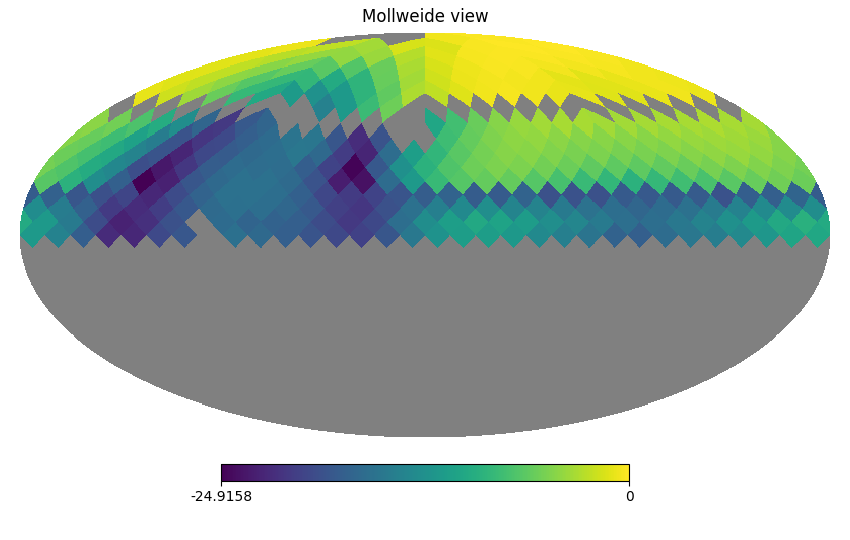

In [66]:
hp.mollview(beam)

<IPython.core.display.Javascript object>


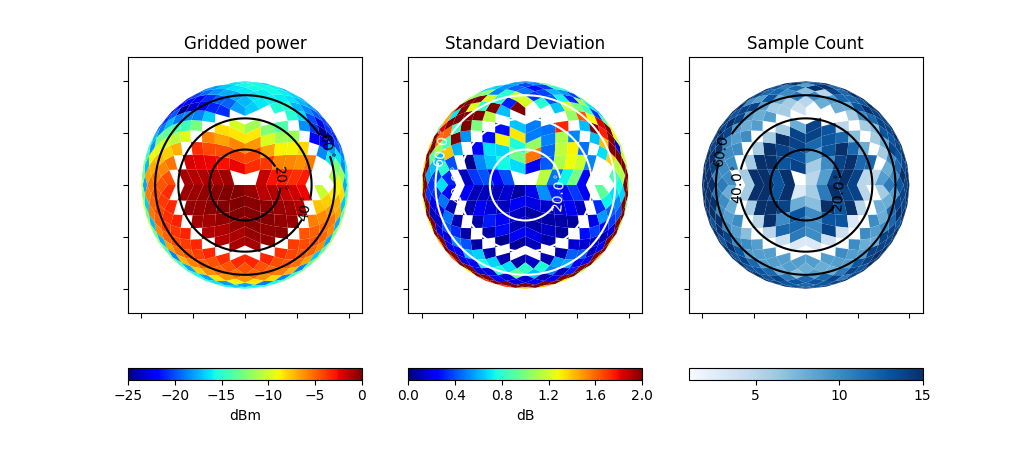

1.0 21.0


In [69]:
plt.figure()
ax1 = plt.subplot(131)
ax1.axis('equal')
beamcoll = plot_utils.make_polycoll(beam,cmap=matplotlib.cm.jet)
beamcoll.set_clim(-25,0)
ax1.add_collection(beamcoll)
CS = ax1.contour(X,Y,THETA*180/np.pi,[20,40,60],colors='k')
CS.levels = [plot_utils.nf(val) for val in CS.levels]
plt.clabel(CS, inline=1, fontsize=10,fmt=plot_utils.fmt)
ax1.autoscale_view()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_title('Gridded power')
cb = plt.colorbar(beamcoll, ax=ax1,orientation='horizontal')
tick_locator = matplotlib.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label('dBm')

#make the std plot
ax2 = plt.subplot(132)
ax2.axis('equal')
#print(hpx_rms)
rmscoll = plot_utils.make_polycoll(rms,cmap=cm.jet)
rmscoll.set_clim(0,2)
ax2.add_collection(rmscoll)
ax2.autoscale_view()
ax2.set_title('Standard Deviation')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
CS = ax2.contour(X,Y,THETA*180/np.pi,[20,40,60],colors='w')
plt.clabel(CS, inline=1, fontsize=10,fmt=fmt)
cb = plt.colorbar(rmscoll, ax=ax2,orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label('dB')

#make the count plot
ax3 = plt.subplot(133)
ax3.axis('equal')
print(counts.min(),counts.max())
cmap = cmap_discretize(cm.bone_r,10)
countscoll = plot_utils.make_polycoll(counts,cmap='Blues')
countscoll.set_clim(1,15)
ax3.add_collection(countscoll)
ax3.autoscale_view()
ax3.set_title('Sample Count')
ax3.set_yticklabels([])
ax3.set_xticklabels([])
CS = plt.contour(X,Y,THETA*180/np.pi,[20,40,60],colors='k')
plt.clabel(CS, inline=1, fontsize=10,fmt=fmt)
cb = plt.colorbar(countscoll, ax=ax3,orientation='horizontal')